In [1]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import src.utils as utils

from src.Data import Data
from src.Camera import Camera
from src.Plot import Plot
from src.VisualOdometry import VisualOdometry

import matplotlib.pyplot as plt

In [2]:
data = Data()
camera = Camera('data/camera.dat')

Ground truth pose: 
 [[1.       0.       0.       0.200426]
 [0.       1.       0.       0.      ]
 [0.       0.       1.       0.      ]
 [0.       0.       0.       1.      ]]
Estimated pose: 
 [[ 1.  0.  0. -0.]
 [-0.  1.  0. -0.]
 [-0. -0.  1. -1.]
 [ 0.  0.  0.  1.]]


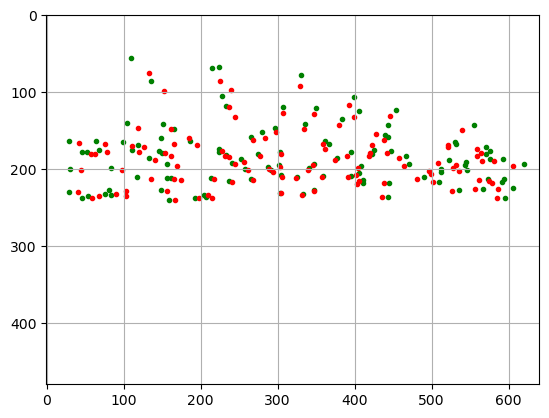

In [6]:
vo = VisualOdometry(camera, data)
vo.initialize()

index = 1

measurements = data.get_measurement_points(0)
matches = vo.data_association(measurements, vo.get_map())
image_points = matches['points_1']
world_points = matches['points_2']
appearances = matches['appearances']

gt_pose = data.get_trajectory()[index]['ground_truth_pose'] + [0, 0, 0]
w_T_r = utils.v2T(np.array(gt_pose))
print('Ground truth pose: \n', w_T_r)

estimated_w_T_r = vo.get_trajectory()['poses'][index]
print('Estimated pose: \n', np.round(estimated_w_T_r, 2))

# r_T_c = camera.get_camera_transform()
# w_T_c = np.dot(estimated_w_T_r, r_T_c)
# estimated_w_T_r = np.dot(estimated_w_T_r, r_T_c)

projected_points = []
projected_points_gt = []
for i in range(len(world_points)):
    proj_camera_point_hom, proj_camera_point, proj_image_point_hom, proj_image_point = camera.project_point(world_points[i])
    if proj_camera_point_hom is None or proj_image_point_hom is None or proj_camera_point is None or proj_image_point is None:
        continue
    projected_points.append(proj_image_point)

    proj_camera_point_hom_gt, proj_camera_point_gt, proj_image_point_hom_gt, proj_image_point_gt = camera.project_point(world_points[i])
    if proj_camera_point_hom_gt is None or proj_image_point_hom_gt is None or proj_camera_point_gt is None or proj_image_point_gt is None:
        continue
    projected_points_gt.append(proj_image_point_gt)

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='green', marker='.')
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='red', marker='.')
#ax.scatter([point[0] for point in projected_points_gt], [point[1] for point in projected_points_gt], color='blue', marker='*')
plt.grid()
plt.show()

In [4]:
pose_0 = vo.get_trajectory()['poses'][0]
pose_1 = vo.get_trajectory()['poses'][1]

world_points = vo.get_map()['points']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

fig.add_trace(go.Scatter3d(x=[pose_0[0, 3]], y=[pose_0[1, 3]], z=[pose_0[2, 3]], mode='markers', marker=dict(size=4, color='red')))
fig.add_trace(go.Scatter3d(x=[pose_1[0, 3]], y=[pose_1[1, 3]], z=[pose_1[2, 3]], mode='markers', marker=dict(size=4, color='blue')))
fig.add_trace(go.Scatter3d(x=[pose_0[0, 3], pose_1[0, 3]], y=[pose_0[1, 3], pose_1[1, 3]], z=[pose_0[2, 3], pose_1[2, 3],], mode='lines', line=dict(color='black', width=2)))

fig.show()

Number of world points:  115


In [5]:
map = vo.get_map()
points = map['points']
appearances = map['appearances']
set_1 = {'points': points, 'appearances': appearances}

set_2 = {'points': [], 'appearances': []}
world = data.get_world()
for i in range(len(world)):
    landmark_position = world[i]['landmark_position']
    landmark_appearances = world[i]['landmark_appearance']
    set_2['points'].append(landmark_position)
    set_2['appearances'].append(landmark_appearances)

matches = vo.data_association(set_1, set_2)
map_points = matches['points_1']
world_points = matches['points_2']

x_coords = [point[0]*0.204 for point in map_points]
y_coords = [point[1]*0.204 for point in map_points]
z_coords = [point[2]*0.204 for point in map_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='red')))
fig.show()


In [6]:
for i in range(2,121):
    vo.one_step(i)

trajectory = vo.get_trajectory()
poses = trajectory['poses']
positions = [list(pose[:3, 3]) for pose in poses]
print('Estimated trajectory:', positions)

trajectory = data.get_trajectory()
gt_trajectory = []
for i in range(120):
    gt_trajectory.append(trajectory[i]['ground_truth_pose'])

print('Ground truth trajectory:', gt_trajectory)

fig = go.Figure()
x_coords = [position[0] for position in positions]
y_coords = [position[1] for position in positions]
z_coords = [position[2] for position in positions]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='lines', name='Estimated trajectory', line=dict(color='red')))

x_coords = [position[0] for position in gt_trajectory]
y_coords = [position[1] for position in gt_trajectory]
z_coords = [position[2] for position in gt_trajectory]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='lines', name='Ground truth trajectory', line=dict(color='green')))

fig.show()

Number of matches: 108
Number of inliers: 108, Chi stats: 166062.381848022

Number of matches: 112
Number of inliers: 112, Chi stats: 760617.7679744001

Number of matches: 99
Number of inliers: 98, Chi stats: 1436294.6057448736

Number of matches: 91
Number of inliers: 87, Chi stats: 2029896.612596919

Number of matches: 89
Number of inliers: 0, Chi stats: 0

Number of matches: 92
Number of inliers: 0, Chi stats: 0

Number of matches: 85
Number of inliers: 0, Chi stats: 0

Number of matches: 77
Number of inliers: 0, Chi stats: 0

Number of matches: 81
Number of inliers: 0, Chi stats: 0

Number of matches: 89
Number of inliers: 0, Chi stats: 0

Number of matches: 96
Number of inliers: 0, Chi stats: 0

Number of matches: 95
Number of inliers: 0, Chi stats: 0

Number of matches: 92
Number of inliers: 0, Chi stats: 0

Number of matches: 88
Number of inliers: 0, Chi stats: 0

Number of matches: 88
Number of inliers: 0, Chi stats: 0

Number of matches: 84
Number of inliers: 0, Chi stats: 0



In [7]:
world_points = vo.get_map()['points']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=1)))

fig.show()

Number of world points:  490
